## Overview

**Time evolution** refers to (computationally) solving for the dynamics of a quantum system given an initial state and Hamiltonian. From the Schrodinger equation ($\hbar = 1$) $ \dot{\psi} = - i H \psi ,$ we can immediately write down the solution $ \psi(t) = \psi(0) \exp(-i H t)$ (for time-independent $H$). But how do you actually evaluate $\exp(-i H t)$? As this is a central question many techniques and approximations have been developed. You will implement one important and widely applicable approximation known as Trotterization (or the Trotter formula) to do this.

<h3><center><a href="https://indico.ectstar.eu/event/250/">ECT* DTP-TALENT 2025: Quantum Computing For Nuclear Physics</a></center></h3>

<h1><center>Time evolution via Trotter</center></h1>

## Setup

Install packages here. You are free to use any quantum information software package like [Cirq](https://quantumai.google/cirq), [Qiskit](https://qiskit.org/), or [QuTiP](https://qutip.org/). For the exact numerics, use NumPy and SciPy.

In [ ]:
!pip install cirq-core qiskit qiskit_aer --quiet

In [ ]:
import itertools
import functools

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
import tqdm

# If you want to use good software.
import cirq

# If you want to use a cloud quantum computer (or want to use bad software and/or like misery).
import qiskit
import qiskit_aer

In [ ]:
"""[Unimportant] Set notebook options."""
import warnings
warnings.filterwarnings("ignore", category=tqdm.TqdmDeprecationWarning)

plt.rcParams.update({"font.family": "serif", "font.size": 16})
plot_options = {"cmap": "bwr", "vmin": -1.0, "vmax": 1.0, "shading": "nearest"}

## (1) Quantum simulation

We will consider the one-dimensional transverse-field Ising model (TFIM) on $n$ sites (qubits) with periodic boundary conditions

$$ H = J \sum_{i = 1}^{n} Z_i Z_{i + 1} - \Gamma \sum_{i = 1}^{n} X_i .$$

Here $X$ and $Z$ are Pauli operators which in the computational basis have matrices

$$ X = \left[ \begin{matrix} 0 & 1 \\ 1 & 0 \end{matrix} \right], \qquad Z = \left[ \begin{matrix} 1 & 0 \\ 0 & -1 \end{matrix} \right] . $$

Subscripts refer to the sites (qubits) the Pauli acts on, and products are tensor products. So, for example, $Z_1 Z_2 \equiv Z_1 \otimes Z_2 \equiv Z \otimes Z \otimes I$ with $n = 3$.

### Exact calculations

Before we start with approximations, let's do some classical brute-force, exact (unscalable) calculations.

#### (1.1) A function for the TFIM Hamiltonian

> Write a function to return the TFIM Hamiltonian $H$ as a NumPy array for a given $n$, $J$, and $\Gamma$.

In [ ]:
def get_tfim_hamiltonian(
    nqubits: int,
    coupling: float = 1,
    gamma: float = 0.25,
) -> np.ndarray:
    qubits = cirq.LineQubit.range(nqubits)

    pauli_sum = coupling * sum(
        cirq.Z.on(qubits[i]) * cirq.Z.on(qubits[(i + 1) % nqubits]) for i in range(nqubits)
    ) - gamma * sum(cirq.X.on(qubits[i]) for i in range(nqubits))

    return pauli_sum.matrix()

In [ ]:
get_tfim_hamiltonian(nqubits=3).real

array([[ 3.  , -0.25, -0.25,  0.  , -0.25,  0.  ,  0.  ,  0.  ],
       [-0.25, -1.  ,  0.  , -0.25,  0.  , -0.25,  0.  ,  0.  ],
       [-0.25,  0.  , -1.  , -0.25,  0.  ,  0.  , -0.25,  0.  ],
       [ 0.  , -0.25, -0.25, -1.  ,  0.  ,  0.  ,  0.  , -0.25],
       [-0.25,  0.  ,  0.  ,  0.  , -1.  , -0.25, -0.25,  0.  ],
       [ 0.  , -0.25,  0.  ,  0.  , -0.25, -1.  ,  0.  , -0.25],
       [ 0.  ,  0.  , -0.25,  0.  , -0.25,  0.  , -1.  , -0.25],
       [ 0.  ,  0.  ,  0.  , -0.25,  0.  , -0.25, -0.25,  3.  ]])

*Note: The Hamiltonian is sparse and can be more compactly represented with objects in [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html). Here we just use (dense) NumPy arrays for simplicity with the small ($n = 10$) problem size.*

> For the remaining problems, use the TFIM Hamiltonian $H$ with $n = 10$, $J = 1$, and $\Gamma = 0.25$.


#### (1.2) Exact time evolution to compute magnetization

> Compute and plot the magnetization $\langle Z_j \rangle (t) =  \langle \psi(t) | Z_j | \psi(t) \rangle$ for each site (qubit) $j = 1, ..., 10$ and each time $t$ in `np.linspace(0, 50, 100)`.
>
> - Here, $|\psi(t)\rangle = \exp(-i H t) |\psi(0)\rangle$
> - Use $|\psi(0)\rangle = |0000100000\rangle$ for the initial state. (All spins down except for one spin up in the middle.)
>
> For plotting, use [`matplotlib.pyplot.imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) or [`matplotlib.pyplot.pcolormesh`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html) or similar.

In [ ]:
"""Set parameters for Hamiltonian."""
nqubits = 8
coupling = 1.0
gamma = 0.25

ham = get_tfim_hamiltonian(nqubits=nqubits, coupling=coupling, gamma=gamma)

In [ ]:
"""Set parameters for initial state."""
qubits = cirq.LineQubit.range(nqubits)
upqubit = nqubits // 2 - 1

In [ ]:
"""Set parameters for time evolution."""
tmin = 0.0
tmax = 50.0
tsteps = 100

times = np.linspace(tmin, tmax, tsteps)

In [ ]:
"""Compute magnetizations via exact time evolution."""
# Allocate array to store the magnetizations.
magnetizations = np.empty(shape=(tsteps, nqubits))

# Set the initial state.
istates = [cirq.KET_ZERO.state_vector()] * nqubits
istates[upqubit] = cirq.KET_ONE.state_vector()
istate = functools.reduce(np.kron, istates)

# Do the time evolution.
for t in tqdm.tqdm_notebook(range(tsteps)):
    # Compute the time-evolved state. This is what we'll use Trotterization for in the next problem!
    psi = scipy.linalg.expm(-1j * ham * times[t]) @ istate

    # Compute the magnetization per site.
    for j in range(nqubits):
        observable = cirq.Z.on(qubits[j]).matrix(qubits)
        magnetization = np.real_if_close(psi.conj().T @ observable @ psi)
        magnetizations[t, j] = magnetization

  0%|          | 0/100 [00:00<?, ?it/s]

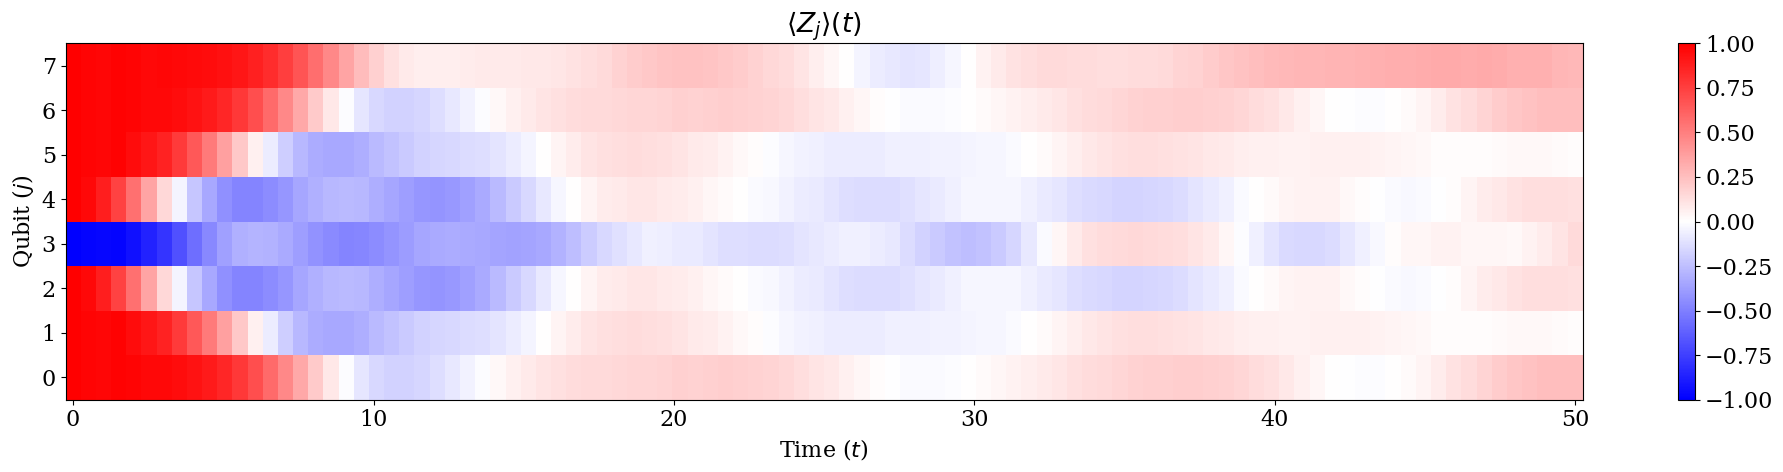

In [ ]:
"""Plot magnetizations."""
plt.figure(figsize=(20, 5))

plt.pcolormesh(times, range(nqubits), magnetizations.T, **plot_options)

plt.xlabel(r"Time ($t$)")
plt.ylabel(r"Qubit ($j$)")
plt.title(r"$\langle Z_j \rangle (t)$")

plt.colorbar()
plt.tight_layout();

### Trotterized time evolution

Consider a Hamiltonian $H = H_A + H_B$. If $[H_A, H_B] = 0$ (square brackets denote commutation), exponentiation is very simple: $\exp(-i H t) = \exp(-i H_A t) \exp(-i H_B t)$.

Of course $[H_A, H_B] \neq 0$ in general. The [first order (Lie-) Trotter (-Suzuki) formula](https://simons.berkeley.edu/sites/default/files/docs/15639/trottererrortheorysimons.pdf) says that, if $||H_A||, ||H_B|| \le 1$,

$$ \exp (- i (H_A + H_B) t) = \exp(-i H_A t) \exp(-i H_B t) + O(|| [H_A, H_B] || t^2) .$$

For the TFIM we can split our Hamiltonian into two mutually commuting groups, namely $H_Z := J \sum_{i = 1}^{n} Z_i Z_{i + 1}$ and $H_X := - \Gamma \sum_{i = 1}^{n} X_i$, and apply this formula with $H = H_Z + H_X$.



#### (1.3) A function for 1st order Trotter

> Write a function to input time $t$ and return the (quantum circuit) operations for the first-order Trotter formula with the TFIM. Use the same $n$, $J$, and $\Gamma$ as above.

##### Using Cirq

In [ ]:
# TODO: Complete either the _unitary_ or the _decompose_ method in the custom gate below,
#  then complete the trotter_step function.
class ExpZZ(cirq.Gate):
    def __init__(self, theta):
        super(ExpZZ, self)
        self.theta = theta

    def _num_qubits_(self):
        return 2

    # Use the unitary...
    def _unitary_(self):
        pass  # TODO: Your code here.

    # ...or use a decomposition.
    # def _decompose_(self, qubits):
    #     a, b = qubits
    #     yield cirq.CNOT(a, b)
    #     yield ...

    def _circuit_diagram_info_(self, args):
        return f"ExpZZ({self.theta})"


def trotter_step(time: float) -> cirq.OP_TREE:
    pass # Your code here.

##### Using Qiskit

In [ ]:
# If you're using Qiskit, write a function to do this task here. An optional template is provided.
def trotter_step_qiskit(
    circuit_qiskit: qiskit.QuantumCircuit,
    qreg: qiskit.QuantumRegister,
    time: float,
    add_barriers: bool = True,
) -> None:
    pass  # Your code here.

#### (1.4) Simulation to compute the magnetization per qubit

> Simulate your circuit using $10^4$ shots (samples) to compute the magnetization per qubit using the same parameters as above, and plot the result.

In [ ]:
# Set parameters. Note: `ntrotter` introduced in problem (1.5).
nshots = 10_000
ntrotter = 1

##### Using Cirq

*Note:* This cell assumes some variables, e.g. that you kept the name `trotter_step` from the template function. Update as needed.

In [ ]:
# Allocate array to store magnetizations.
magnetizations_trotter = np.empty(shape=(tsteps, nqubits))

for t in tqdm.tqdm_notebook(range(tsteps)):
    # Get the circuit to do 1st order Trotter.
    circuit = cirq.Circuit(
        # Initial state.
        cirq.Moment(cirq.X.on(qubits[upqubit])),
        # Trotter step(s).
        [trotter_step(times[t] / ntrotter) for _ in range(ntrotter)],
        # Measurements.
        cirq.Moment(cirq.measure(qubits[i], key=str(i)) for i in range(nqubits)),
    )

    # Sample from the circuit.
    result = cirq.Simulator().run(circuit, repetitions=nshots)

    # Compute and store magnetiziations.
    for j in range(nqubits):
        measurements = result.histogram(key=str(j))
        magnetization = (measurements.get(0, 0.0) - measurements.get(1, 0.0)) / nshots
        magnetizations_trotter[t, j] = magnetization

In [ ]:
"""Plot the magnetizations."""
plt.figure(figsize=(20, 5))

plt.pcolormesh(times, range(nqubits), magnetizations_trotter.T, **plot_options)

plt.xlabel(r"Time ($t$)")
plt.ylabel(r"Qubit ($j$)")
plt.title(rf"$\langle Z_j \rangle (t)$ via {ntrotter} 1st order Trotter step(s)")

plt.colorbar()
plt.tight_layout();

##### Using Qiskit

In [ ]:
# Your code here.

#### (1.5) Increasing the number of Trotter steps

You should see that the previous result is poor! (Decent for the first few time steps, but very innacurate after.) This can be improved by implementing a number $r$ of Trotter steps, essentially repeating the above circuit $r$ times where each Trotter step is done for time $t / r$. Specifically, the first-order Trotter formula with $r$ steps says that

$$ \exp (- i (H_A + H_B) t) = [\exp(-i H_A t / r) \exp(-i H_B t / r)]^r + O\left( \frac{|| [H_A, H_B] || t^2}{r}\right) .$$

This is now nice because the error goes to zero as $r \rightarrow \infty$, and we can decrease the error by using more steps. The cost, of course, is more gates in the circuit.

> Do the same simulation as (1.4) but now using $r = 10, 20,$ and $40$ Trotter steps. Plot the results and compare to the exact solution.

In [ ]:
# Set parameters.
nshots = 10_000
ntrotter = 40

# Allocate array to store magnetizations.
magnetizations_trotter = np.empty(shape=(tsteps, nqubits))

for t in tqdm.notebook.tqdm(range(tsteps)):
    # Get the circuit to do 1st order Trotter.
    circuit = cirq.Circuit(
        # Initial state.
        cirq.Moment(cirq.X.on(qubits[upqubit])),
        # Trotter step(s).
        [trotter_step(times[t] / ntrotter) for _ in range(ntrotter)],
        # Measurements.
        cirq.Moment(cirq.measure(qubits[i], key=str(i)) for i in range(nqubits)),
    )

    # Sample from the circuit.
    result = cirq.Simulator().run(circuit, repetitions=nshots)

    # Compute and store magnetiziations.
    for j in range(nqubits):
        measurements = result.histogram(key=str(j))
        magnetization = (measurements.get(0, 0.0) - measurements.get(1, 0.0)) / nshots
        magnetizations_trotter[t, j] = magnetization

In [ ]:
"""Plot the magnetizations."""
plt.figure(figsize=(20, 5))

plt.pcolormesh(times, range(nqubits), magnetizations_trotter.T, **plot_options)

plt.xlabel(r"Time ($t$)")
plt.ylabel(r"Qubit ($j$)")
plt.title(rf"$\langle Z_j \rangle (t)$ via {ntrotter} 1st order Trotter step(s)")

plt.colorbar()
plt.tight_layout();

### Further reading and exercises

- Re-implement this exercise with another Hamiltonian, e.g. the Lipkin model.
- Compute expectation values from the final time-evolved state, e.g. the energy $\langle \psi(t) | H | \psi(t) \rangle$.
- We looked at the first-order Trotter formula, but there are higher orders: Read more, e.g., [here](https://simons.berkeley.edu/sites/default/files/docs/15639/trottererrortheorysimons.pdf) and in the [Theory of Trotter error](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.011020).
- You may be interested in [imaginary time evolution](https://www.nature.com/articles/s41534-021-00409-y), another technique to find the ground state of a time-independent Hamiltonian.
- Want to simulate a time-dependent Hamiltonian? You may want to know about the [quantum adiabatic theorem](http://www.cs.umd.edu/~amchilds/teaching/w08/l18.pdf).